In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
def load_audio_16k(filename, mono=False):
    audio = tfio.audio.AudioIOTensor(filename, dtype=tf.float32)

    sample_rate = tf.cast(audio.rate, dtype=tf.int64)

    audio = audio[:]

    if mono:
        audio = audio[:,0]
    
    audio = tfio.audio.resample(audio, rate_in=sample_rate, rate_out=16000)

    return audio

In [3]:
def preprocess(file_path, label):
    audio = load_audio_16k(file_path)
    #Using two channels
    step1 = len(audio[:,0]) // 16
    step2 = len(audio[:,0]) // 33

    labels = np.ones((30,1), dtype=np.float32) * label


    steps1 = np.arange(15)*step1
    steps2 = np.arange(start=1, stop=30, step=2)*step2
    audioWindow = np.arange(10000, 58000).reshape(-1,1)
    audioWindow1 = audioWindow + steps1
    audioWindow2 = audioWindow + steps2


    audio = tf.transpose(tf.concat([tf.gather(audio[:,0], audioWindow1), tf.gather(audio[:,1], audioWindow2)], 1))

    spectrograms = tfio.audio.spectrogram(audio, nfft=512, window=960, stride=240)
    spectrograms = tfio.audio.melscale(spectrograms, rate=16000, mels=100, fmin=0, fmax=4000)
    spectrograms = tfio.audio.dbscale(spectrograms, top_db=70)

    spectrograms = tf.expand_dims(spectrograms, axis=3)
    
    return spectrograms, labels

In [6]:
b, _ = preprocess(os.path.join('/kaggle/input/musicbpm','data', 'Training', '94_Zankoku na Tenshi no These.mp3'), 94)

In [5]:
a, _ = preprocess(os.path.join('/kaggle/input/musicbpm','data', 'Testing', '164_Kuchizuke Diamond.mp3'), 164)

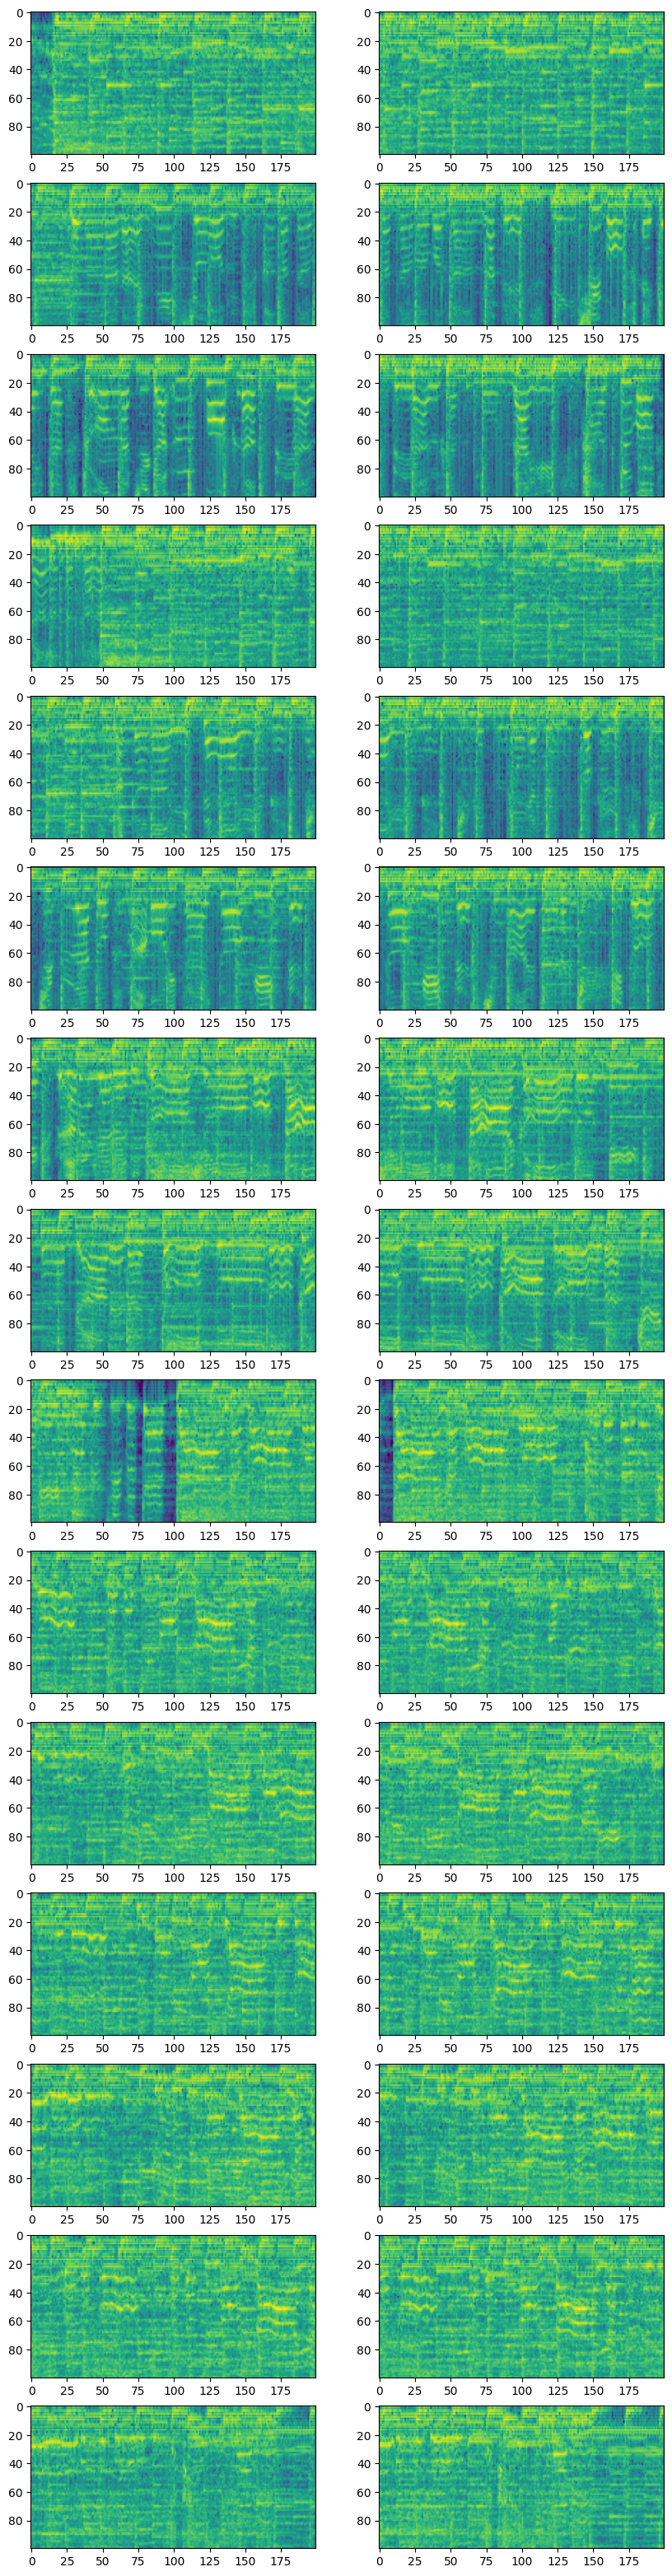

In [6]:
temp = a
plt.figure(figsize=(10,40))
for i, spectro in enumerate(temp[:len(temp) // 2]):
    plt.subplot(len(temp) // 2, 2, 1 + 2*i)
    plt.imshow(tf.transpose(spectro)[0])

for i, spectro in enumerate(temp[len(temp) // 2:]):
    plt.subplot(len(temp) // 2, 2, 2 + 2*i)
    plt.imshow(tf.transpose(spectro)[0])

In [4]:
def getDataPaths(*path):
    dataRelativePath = os.path.join(*path)

    supportedAudioFiles = ['/*.flac', '/*.wav', '/*.ogg', '/*.mp3', '/*.mp4a']
    supportedAudioFilesGlob = []

    for supportedAudioFile in supportedAudioFiles:
        supportedAudioFilesGlob.append(dataRelativePath + supportedAudioFile)

    dataPaths = tf.data.Dataset.list_files(supportedAudioFilesGlob, shuffle=False, seed=1234)
    return dataRelativePath, dataPaths

In [5]:
def getLabels(dataRelativePath, dataPaths):
    labels = []
    fileIndex = len(dataRelativePath)
    for elem in dataPaths:
        fileStringPath = elem.numpy().decode('utf-8')
        underscoreIndex = fileStringPath.find('_',fileIndex)
        labels.append(float(fileStringPath[fileIndex + 1:underscoreIndex]))
    
    return labels

In [6]:
def getData(*args):
    dataRelativePath, dataPaths = getDataPaths(*args)
    labels = getLabels(dataRelativePath, dataPaths)
    labels = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((dataPaths, labels))

In [7]:
def datasetConfiguration(dataset, preprocessFunction):
    dataset = dataset.map(preprocessFunction)
    dataset = dataset.unbatch()
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=len(dataset) + 1)
    dataset = dataset.batch(16)
    dataset = dataset.prefetch(8)
    return dataset

In [8]:
def datasetPartition(dataset):
    trainingBatches = len(dataset) * 7 //10
    testBatches = len(dataset) - trainingBatches
    train = dataset.take(trainingBatches)
    test = dataset.skip(trainingBatches).take(testBatches)
    return train, test

In [9]:
data = getData('/kaggle/input/musicbpm','data', 'Training')

In [10]:
data = datasetConfiguration(data, preprocess)

In [11]:
train, test = datasetPartition(data)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, SeparableConv2D, InputLayer
from tensorflow.keras.layers import Dropout, BatchNormalization, MaxPool2D, GlobalMaxPool2D

In [16]:
def createModelTE(inputShape = (200, 100, 1)):
    model = Sequential(name="sequentialTE")
    model.add(InputLayer(inputShape))
    model.add(Conv2D(16, (3,3), activation='relu'))
    model.add(MaxPool2D((2,1)))
    
    model.add(SeparableConv2D(32, (3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(BatchNormalization())
    
    model.add(SeparableConv2D(64, (3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(BatchNormalization())
    
    model.add(SeparableConv2D(128, (3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(BatchNormalization())
    
    model.add(SeparableConv2D(256, (3,3), activation='relu'))
    model.add(MaxPool2D((2,2)))
    model.add(BatchNormalization())
    
    model.add(GlobalMaxPool2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error', 
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name="mape"), 
                       tf.keras.metrics.MeanSquaredError(name="mse")])
    return model
modelTe = createModelTE()
modelTe.summary()

Model: "sequentialTE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 98, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 98, 16)       0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 97, 96, 32)       688       
 Conv2D)                                                         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                        

In [17]:
def scheduler(epoch, lr):
    if lr <= 0.000001:
        return lr
    if epoch % 5 == 0 and epoch > 1:
        return lr * 0.8
    return lr

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=0.000001, verbose=1)
schedule_lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
early_s = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)

In [18]:
modelTe.fit(train, epochs=15, validation_data=test, callbacks=[reduce_lr, schedule_lr, early_s])

Epoch 1/15
656/656 [==============================] - 763s 149ms/step - loss: 3519.0735 - mape: 30.3812 - mse: 3519.0735 - val_loss: 2344.0813 - val_mape: 25.0869 - val_mse: 2344.0813 - lr: 0.0010
Epoch 2/15
656/656 [==============================] - 99s 151ms/step - loss: 2664.7366 - mape: 26.9806 - mse: 2664.7366 - val_loss: 3069.9399 - val_mape: 32.2008 - val_mse: 3069.9399 - lr: 0.0010
Epoch 3/15
656/656 [==============================] - ETA: 0s - loss: 2510.8882 - mape: 26.1049 - mse: 2510.8882
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
656/656 [==============================] - 102s 155ms/step - loss: 2510.8882 - mape: 26.1049 - mse: 2510.8882 - val_loss: 2388.1038 - val_mape: 22.4933 - val_mse: 2388.1038 - lr: 8.0000e-04
Epoch 4/15
656/656 [==============================] - 99s 150ms/step - loss: 2353.0659 - mape: 25.3600 - mse: 2353.0659 - val_loss: 1889.2654 - val_mape: 24.3429 - val_mse: 1889.2654 - lr: 8.0000e-04
Epoch 5/15
656/656 [=========

In [19]:
modelTe.save('/kaggle/working/musicFULLMODEL15E.h5')

In [20]:
modelTe.fit(train, epochs=15, validation_data=test, callbacks=[reduce_lr, schedule_lr, early_s])

Epoch 1/15
656/656 [==============================] - 91s 139ms/step - loss: 947.5060 - mape: 15.2906 - mse: 947.5060 - val_loss: 563.5704 - val_mape: 12.3116 - val_mse: 563.5704 - lr: 4.0960e-04
Epoch 2/15
656/656 [==============================] - 91s 139ms/step - loss: 935.9514 - mape: 15.1528 - mse: 935.9514 - val_loss: 635.4518 - val_mape: 11.7866 - val_mse: 635.4518 - lr: 4.0960e-04
Epoch 3/15
656/656 [==============================] - 92s 141ms/step - loss: 864.3146 - mape: 14.5982 - mse: 864.3146 - val_loss: 526.2789 - val_mape: 12.0227 - val_mse: 526.2789 - lr: 4.0960e-04
Epoch 4/15
656/656 [==============================] - 111s 170ms/step - loss: 828.9589 - mape: 14.3194 - mse: 828.9589 - val_loss: 490.2729 - val_mape: 10.5988 - val_mse: 490.2729 - lr: 4.0960e-04
Epoch 5/15
656/656 [==============================] - 109s 167ms/step - loss: 814.2911 - mape: 13.9719 - mse: 814.2911 - val_loss: 670.0124 - val_mape: 12.1029 - val_mse: 670.0124 - lr: 4.0960e-04
Epoch 6/15
656/656

In [21]:
modelTe.save('/kaggle/working/musicFULLMODEL30E.h5')

In [22]:
modelTe.fit(train, epochs=15, validation_data=test, callbacks=[reduce_lr, schedule_lr, early_s])

Epoch 1/15
656/656 [==============================] - 100s 152ms/step - loss: 484.4507 - mape: 10.5700 - mse: 484.4507 - val_loss: 168.7293 - val_mape: 6.4782 - val_mse: 168.7293 - lr: 2.0972e-04
Epoch 2/15
656/656 [==============================] - 101s 153ms/step - loss: 473.9854 - mape: 10.3789 - mse: 473.9854 - val_loss: 183.2521 - val_mape: 6.8077 - val_mse: 183.2521 - lr: 2.0972e-04
Epoch 3/15
656/656 [==============================] - 93s 141ms/step - loss: 448.2072 - mape: 10.0700 - mse: 448.2072 - val_loss: 165.1769 - val_mape: 6.2644 - val_mse: 165.1769 - lr: 2.0972e-04
Epoch 4/15
656/656 [==============================] - 92s 140ms/step - loss: 447.2070 - mape: 10.1261 - mse: 447.2070 - val_loss: 155.4878 - val_mape: 6.2114 - val_mse: 155.4878 - lr: 2.0972e-04
Epoch 5/15
656/656 [==============================] - 92s 141ms/step - loss: 430.7854 - mape: 9.9534 - mse: 430.7854 - val_loss: 151.9906 - val_mape: 6.2315 - val_mse: 151.9906 - lr: 2.0972e-04
Epoch 6/15
656/656 [====

In [23]:
modelTe.save('/kaggle/working/musicFULLMODEL45E.h5')

In [31]:
modelTe.fit(train, epochs=15, validation_data=test, callbacks=[reduce_lr, schedule_lr, early_s])
modelTe.save('/kaggle/working/musicFULLMODEL60E.h5')

Epoch 1/15
656/656 [==============================] - 92s 140ms/step - loss: 333.6078 - mape: 8.5464 - mse: 333.6078 - val_loss: 71.5461 - val_mape: 4.1877 - val_mse: 71.5461 - lr: 8.5899e-05
Epoch 2/15
656/656 [==============================] - 105s 160ms/step - loss: 335.5306 - mape: 8.5624 - mse: 335.5306 - val_loss: 80.6392 - val_mape: 4.4281 - val_mse: 80.6392 - lr: 8.5899e-05
Epoch 3/15
656/656 [==============================] - ETA: 0s - loss: 329.5208 - mape: 8.5476 - mse: 329.5208
Epoch 3: ReduceLROnPlateau reducing learning rate to 6.871948717162013e-05.
656/656 [==============================] - 102s 155ms/step - loss: 329.5208 - mape: 8.5476 - mse: 329.5208 - val_loss: 75.4480 - val_mape: 4.3046 - val_mse: 75.4480 - lr: 6.8719e-05
Epoch 4/15
656/656 [==============================] - 96s 146ms/step - loss: 330.3034 - mape: 8.4959 - mse: 330.3034 - val_loss: 92.2821 - val_mape: 4.6947 - val_mse: 92.2821 - lr: 6.8719e-05
Epoch 5/15
656/656 [==============================] - 9

In [32]:
modelTe.fit(train, epochs=15, validation_data=test, callbacks=[reduce_lr, schedule_lr, early_s])
modelTe.save('/kaggle/working/musicFULLMODEL75E.h5')

Epoch 1/15
656/656 [==============================] - 104s 158ms/step - loss: 294.5062 - mape: 7.9459 - mse: 294.5062 - val_loss: 55.2425 - val_mape: 3.5165 - val_mse: 55.2425 - lr: 2.8147e-05
Epoch 2/15
656/656 [==============================] - 103s 157ms/step - loss: 287.5710 - mape: 7.8076 - mse: 287.5710 - val_loss: 44.3834 - val_mape: 3.2577 - val_mse: 44.3834 - lr: 2.8147e-05
Epoch 3/15
656/656 [==============================] - 98s 149ms/step - loss: 276.1110 - mape: 7.7077 - mse: 276.1110 - val_loss: 61.5055 - val_mape: 3.8768 - val_mse: 61.5055 - lr: 2.8147e-05
Epoch 4/15
656/656 [==============================] - 90s 137ms/step - loss: 279.8483 - mape: 7.7766 - mse: 279.8483 - val_loss: 37.8360 - val_mape: 3.0126 - val_mse: 37.8360 - lr: 2.8147e-05
Epoch 5/15
656/656 [==============================] - 90s 138ms/step - loss: 286.4365 - mape: 7.8412 - mse: 286.4365 - val_loss: 37.5143 - val_mape: 2.9458 - val_mse: 37.5143 - lr: 2.8147e-05
Epoch 6/15
656/656 [==================

In [33]:
modelTe.fit(train, epochs=15, validation_data=test, callbacks=[reduce_lr, schedule_lr, early_s])
modelTe.save('/kaggle/working/musicFULLMODEL90E.h5')

Epoch 1/15
656/656 [==============================] - 99s 150ms/step - loss: 265.4122 - mape: 7.5203 - mse: 265.4122 - val_loss: 36.1057 - val_mape: 2.9024 - val_mse: 36.1057 - lr: 1.1529e-05
Epoch 2/15
656/656 [==============================] - 97s 148ms/step - loss: 273.2221 - mape: 7.6416 - mse: 273.2221 - val_loss: 32.0858 - val_mape: 2.7755 - val_mse: 32.0858 - lr: 1.1529e-05
Epoch 3/15
656/656 [==============================] - 91s 138ms/step - loss: 270.9928 - mape: 7.6361 - mse: 270.9928 - val_loss: 44.0026 - val_mape: 3.2297 - val_mse: 44.0026 - lr: 1.1529e-05
Epoch 4/15
656/656 [==============================] - 90s 137ms/step - loss: 265.2493 - mape: 7.5045 - mse: 265.2493 - val_loss: 31.0940 - val_mape: 2.7697 - val_mse: 31.0940 - lr: 1.1529e-05
Epoch 5/15
656/656 [==============================] - 107s 163ms/step - loss: 267.7716 - mape: 7.4956 - mse: 267.7716 - val_loss: 27.4401 - val_mape: 2.5813 - val_mse: 27.4401 - lr: 1.1529e-05
Epoch 6/15
656/656 [===================

In [24]:
x = test.as_numpy_iterator().next()

In [36]:
au = modelTe.predict(x[0])

1/1 [==============================] - 0s 66ms/step


In [37]:
print(au)
x[1]

[[141.25195 ]
 [251.54434 ]
 [105.96569 ]
 [237.34111 ]
 [181.58733 ]
 [ 77.76244 ]
 [ 90.17747 ]
 [256.941   ]
 [177.96674 ]
 [125.63412 ]
 [292.59665 ]
 [156.91922 ]
 [238.6177  ]
 [115.92479 ]
 [ 91.693214]
 [177.89983 ]]


array([[144.],
       [260.],
       [105.],
       [240.],
       [180.],
       [ 78.],
       [ 80.],
       [255.],
       [185.],
       [130.],
       [280.],
       [158.],
       [242.],
       [107.],
       [ 85.],
       [175.]], dtype=float32)

In [27]:
validationData = getData('/kaggle/input/musicbpm','data', 'Testing')
validationData = datasetConfiguration(validationData, preprocess)

In [28]:
xv = validationData.as_numpy_iterator().next()

In [34]:
yvh = modelTe.predict(xv[0])

1/1 [==============================] - 0s 61ms/step


In [35]:
print(yvh)
xv[1]

[[202.7557 ]
 [153.80482]
 [195.82498]
 [167.87263]
 [161.26414]
 [165.69597]
 [200.47105]
 [159.0247 ]
 [200.4638 ]
 [199.8589 ]
 [198.06065]
 [162.6151 ]
 [160.71724]
 [188.80074]
 [161.45169]
 [201.24677]]


array([[200.],
       [164.],
       [200.],
       [164.],
       [164.],
       [164.],
       [200.],
       [164.],
       [200.],
       [200.],
       [200.],
       [164.],
       [164.],
       [200.],
       [164.],
       [200.]], dtype=float32)